In [1]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from random import random, randint, choice
import matplotlib.pyplot as plt
import math

from sklearn.preprocessing import StandardScaler

In [20]:
def criar_dataset(n = 20_000, n_senoides = 3, amplitude_ruido = 1/5):
    vetor_final = []
    for k in range(n_senoides):
        freq = 1 / randint(10, 60)
        ampl = randint(1, 5)
        vetor_final.append([ampl*math.sin(x*freq) for x in range(n)])
    
    ruido = amplitude_ruido * np.random.rand(n)
    vetor_final += ruido
    
    return np.array(vetor_final).sum(axis=0)

v = criar_dataset(n=20_000, n_senoides=5, amplitude_ruido=0.9)

# Divisão treino-teste

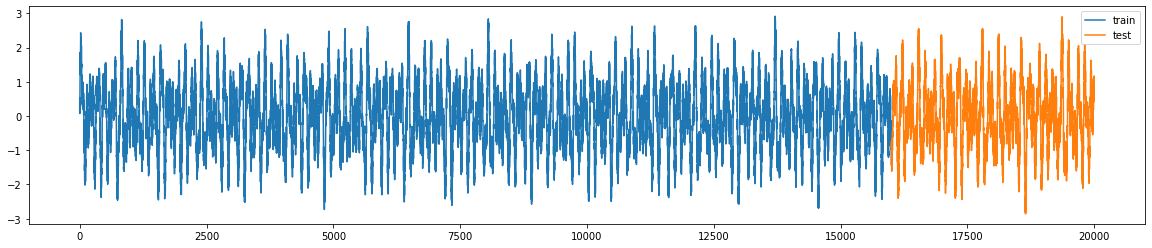

In [21]:
TRAIN_SIZE = int(0.80 * len(v))
train_values, test_values = v[:TRAIN_SIZE], v[TRAIN_SIZE:]

scaler = StandardScaler()
train_values = scaler.fit_transform(train_values.reshape(-1, 1))
test_values = scaler.transform(test_values.reshape(-1, 1))

train_values = train_values.reshape(-1)
test_values = test_values.reshape(-1)

plt.figure(figsize=(20, 4))
plt.plot(np.arange(len(train_values)), train_values, label='train')
plt.plot(len(train_values) + np.arange(len(test_values)), test_values, label='test')
plt.legend()
plt.show()

# Criando os tensores

In [22]:
class custom_dataset(Dataset):

    def __init__(self, df, n_window):
        self.df = df
        self.n_window = n_window
        
        x, y = [], []
        for k in range(n_window, len(self.df), 1):
            x.append(self.df[k-n_window:k])
            y.append(self.df[k])
        
        self.x = torch.tensor(x, dtype=torch.float)
        self.y = torch.tensor(y, dtype=torch.float)

        self.x.unsqueeze_(dim=1)
        self.y.unsqueeze_(dim=1)

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]

N_WINDOW = 6
BATCH_SIZE = 64

train_dataset = custom_dataset(train_values, n_window=N_WINDOW)
test_dataset = custom_dataset(test_values, n_window=N_WINDOW)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

print (f'train_dataset: {len(train_dataset)} instâncias')
print (f'test_dataset: {len(test_dataset)} instâncias')
print (f'train_dataloader: {len(train_dataloader)} batches')
print (f'train_dataset: {len(test_dataloader)} batches')

train_dataset: 15994 instâncias
test_dataset: 3994 instâncias
train_dataloader: 250 batches
train_dataset: 63 batches


In [23]:
# Exemplo de shape do dataloader e dataset
x, y = choice(train_dataset)
print (f'dataset.x.shape: {x.shape}, dataset.y.shape: {y.shape}')

x_batch, y_batch = next(iter(train_dataloader))
print (f'xbatch.shape: {x_batch.shape}, ybatch.shape: {y_batch.shape}')

dataset.x.shape: torch.Size([1, 6]), dataset.y.shape: torch.Size([1])
xbatch.shape: torch.Size([64, 1, 6]), ybatch.shape: torch.Size([64, 1])


# Modelo
- Com LSTM

In [24]:
class custom_model(nn.Module):

    def __init__(self, input_dim, hidden_dim, n_layers):
        super(custom_model, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.lstm = nn.LSTM(input_size=self.input_dim, hidden_size=self.hidden_dim, num_layers=self.n_layers, batch_first=True)
        self.net = nn.Sequential(
            nn.Linear(in_features=self.hidden_dim, out_features=64),
            nn.LeakyReLU(),
            nn.Linear(in_features=64, out_features=1)
        )
    
    def forward(self, x):
        c0 = torch.zeros((self.n_layers, len(x), self.hidden_dim))
        h0 = torch.zeros((self.n_layers, len(x), self.hidden_dim))

        output, (c0, h0) = self.lstm(x, (h0, c0))

        output = output.reshape(len(x), -1)

        return self.net(output)

x, y = next(iter(train_dataloader))
print (f'input.shape: {x.shape}')

model = custom_model(input_dim=6, hidden_dim=32, n_layers=3)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

output = model(x)
print (f'output.shape: {output.shape}')

input.shape: torch.Size([64, 1, 6])
output.shape: torch.Size([64, 1])


# Função Validação

In [25]:
def validar(model_, dataloader_, loss_fn_):
    model_.eval()
    with torch.no_grad():
        test_loss, total_itens = 0, 0
        for x, y_true in dataloader_:
            y_pred = model_(x)
            loss = loss_fn_(y_true, y_pred)
            
            test_loss += loss.item()
            total_itens += len(x)
        
    return test_loss/total_itens

validar(model, test_dataloader, loss_fn)

0.01628597660860421

# Treinamento

In [26]:
cabecalho = ['epoch', 'train_loss', 'test_loss']
print ('|'.join([str(c).center(25) for c in cabecalho]))

resultados = []
for epoch in range(5):
    model.train()
    train_loss, total_itens = 0, 0
    for x, y_true in train_dataloader:
        
        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y_true)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        total_itens += len(x)
    
    test_loss = validar(model, test_dataloader, loss_fn)
    vetor = [epoch, train_loss/total_itens, test_loss]
    resultados.append(vetor)
    print ('|'.join([str(round(v,3)).center(25) for v in vetor]))

resultados = np.array(resultados)

          epoch          |        train_loss       |        test_loss        
            0            |          0.006          |          0.001          
            1            |          0.001          |          0.001          
            2            |          0.001          |          0.001          
            3            |          0.001          |          0.001          
            4            |          0.001          |          0.001          


# Análise Gráfica do treinamento

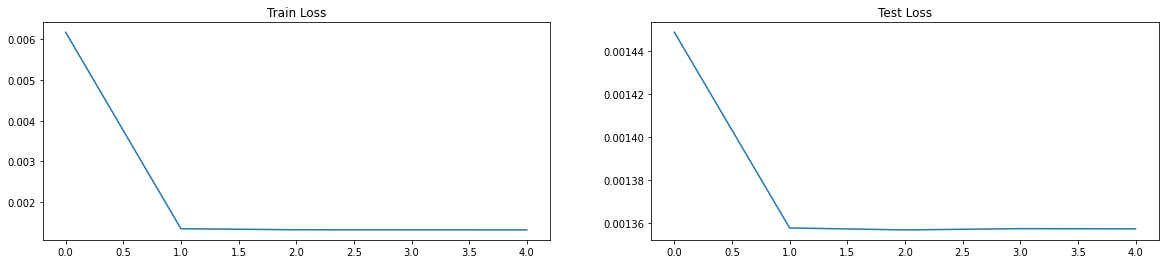

In [27]:
plt.figure(figsize=(20, 4))
plt.subplot(1, 2, 1)
plt.plot(resultados[:,1])
plt.title('Train Loss')

plt.subplot(1, 2, 2)
plt.plot(resultados[:,2])
plt.title('Test Loss')
plt.show()

# Comparação entre real e predito

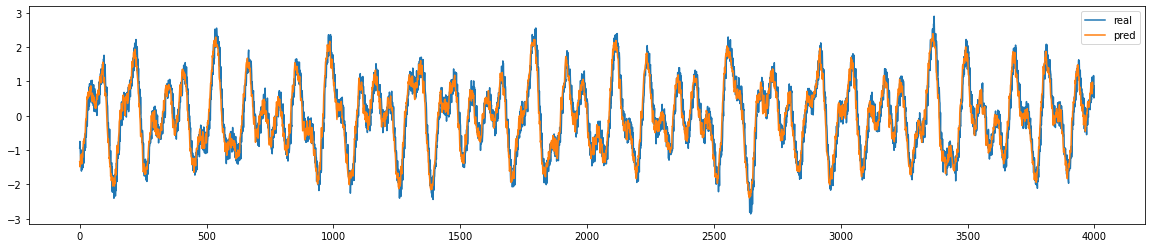

In [28]:
y_pred = []
for x, y_test in test_dataloader:
    y_pred_tensor = model(x)
    y_pred.append(y_pred_tensor.detach().numpy().reshape(-1))

y_pred = np.hstack(y_pred)

plt.figure(figsize=(20, 4))
plt.plot(test_values, label='real')
plt.plot(y_pred, label='pred')
plt.legend()

plt.show()